In [4]:
import pandas as pd
import numpy as np
import torch
import tqdm
import matplotlib.pyplot as plt
from pyDRMetrics.pyDRMetrics import *

from torch import nn

In [5]:
#reading all the files

#reading the first file
df = pd.read_csv('../src/outputs/run_history_19.csv', sep=';', index_col=0)
df_emb = pd.read_csv('../src/outputs/run_history_emb_idx_19.csv', sep=';', index_col=0)
np_emb_state = np.load('../src/outputs/emb_states_19.npy', allow_pickle=True)
np_emb_next_state = np.load('../src/outputs/next_states_19.npy', allow_pickle=True)

skeeped_files = []
#adding all the others
list1 = list(range(39, 5000, 20))
for i in tqdm(list1):
    s1 = '../src/outputs/run_history_' + str(i) + '.csv'
    df_ = pd.read_csv(s1, sep=';', index_col=0)
    s2 = '../src/outputs/emb_states_' + str(i) + '.npy'
    np_emb_state_ = np.load(s2, allow_pickle=True)
    if np_emb_state_.shape[0] != df_.shape[0]:
        print ('skeeping file %d' %i)
        skeeped_files.append(s1)
        skeeped_files.append(s2)
    else:
        df = pd.concat([df,df_], axis=0)
        np_emb_state = np.concatenate((np_emb_state, np_emb_state_))
        
print(df.shape)
print(np_emb_state.shape)

 31%|███       | 77/249 [00:01<00:03, 49.07it/s]

skeeping file 1439


 83%|████████▎ | 207/249 [00:04<00:00, 49.70it/s]

skeeping file 3979


 96%|█████████▋| 240/249 [00:04<00:00, 45.94it/s]

skeeping file 4659
skeeping file 4699


100%|██████████| 249/249 [00:05<00:00, 48.20it/s]

(120311, 8)
(120311,)


In [6]:
np_emb_state[0].shape

(768,)

In [7]:
np_emb_state_float = [x.astype(np.float64) for x in np_emb_state]

In [8]:
from torch.utils.data import TensorDataset, DataLoader

tensor_emb = torch.Tensor(np.array(np_emb_state_float)) 
dataset = TensorDataset(tensor_emb)
print(dataset.__len__())
loader = DataLoader(tensor_emb, batch_size = 64,
   shuffle = True)


120311


In [6]:
# baseline
U, S, V = torch.pca_lowrank(tensor_emb, q=64)

total_var = torch.var(tensor_emb)
total_var_approx = torch.var(V)

cumulative_percent_variance = (total_var_approx / total_var) * 100
print(cumulative_percent_variance)

tensor(0.7109)


In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=64)
principalComponents = pca.fit_transform(tensor_emb)
print(principalComponents.shape)
emb_recon = pca.inverse_transform(principalComponents)
loss_function = torch.nn.MSELoss()
loss = loss_function(tensor_emb, torch.Tensor(emb_recon))
print("Baseline loss with PCA %.8f" %loss)


(120311, 64)
Baseline loss with PCA 0.00110159


explained variance ratio: [0.3204162  0.11869368 0.09340615 0.06423023 0.03484318]
Explained var ratio cumsum: [0.3204162  0.43910988 0.53251603 0.59674626 0.63158944 0.66210178
 0.6877501  0.70441712 0.71877093 0.73214909 0.74421939 0.75412768
 0.76364634 0.77262636 0.78141352 0.78901177 0.79607715 0.80251687
 0.80842719 0.813929   0.81897029 0.82370874 0.82807046 0.83218212
 0.83615942 0.84004125 0.84377582 0.84735281 0.85080345 0.85410905
 0.85723749 0.86019326 0.86305504 0.86590381 0.86857143 0.87108267
 0.87347837 0.87580802 0.87810718 0.8803373  0.88249055 0.88456654
 0.88660873 0.88862593 0.89056882 0.89242548 0.89424566 0.89596915
 0.89765768 0.8992823  0.90085704 0.90237824 0.9038787  0.90535616
 0.90679202 0.90821216 0.90956957 0.91090501 0.91217873 0.91343283
 0.91467003 0.915865   0.91702619 0.9181775 ]
Qlocal =  0.7326336817425556
--- Sample Reconstruction (X and Xr) ---
left column: original waveform		 right column: recovered waveform


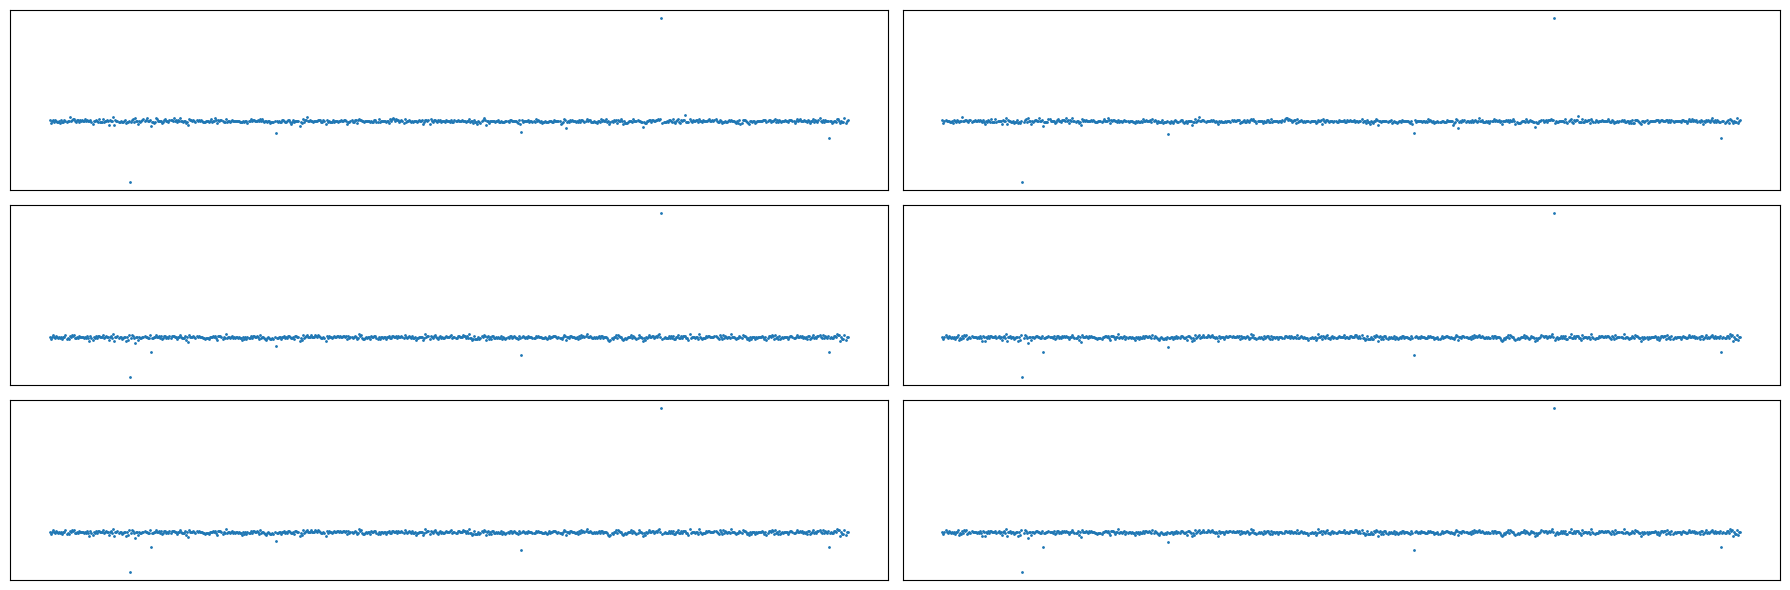

rMSE =  0.006159726198163618
--- Distance Matrices (D and Dz) ---


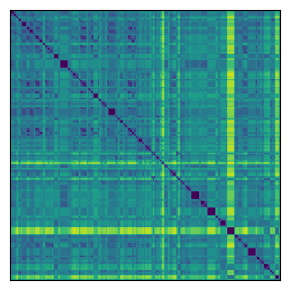

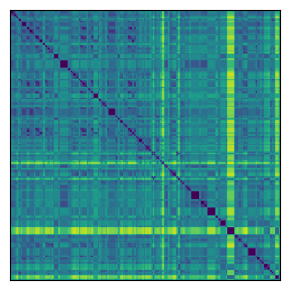

Residual Variance (using Pearson's r) =  0.005762089592484365
Residual Variance (using Spearman's r) =  0.0087011864060772
--- Ranking Matrices (R and Rz) ---


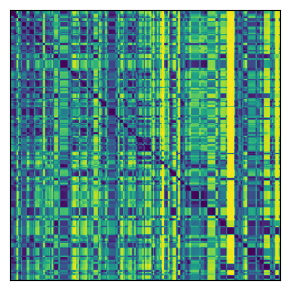

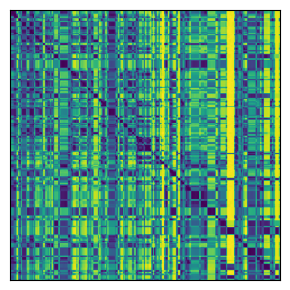

--- Co-ranking Matrix (Q) ---


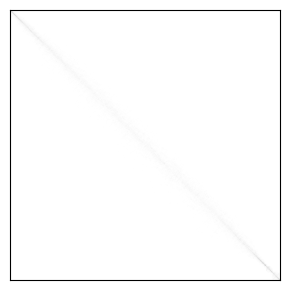

--- Trustworthiness T(k) and Continuity C(k) ---


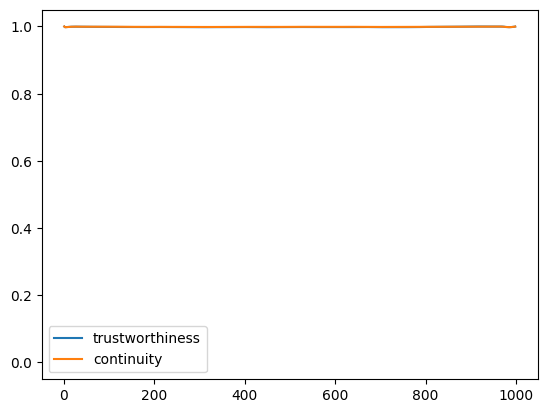

AUC of T =  0.9984933580215646
AUC of C =  0.9989473293004351
--- QNN(k) Curve ---


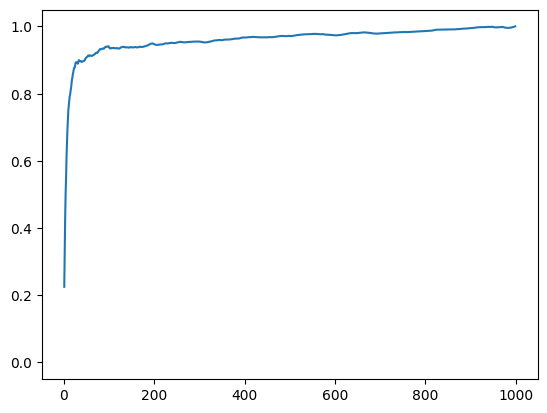

AUC of QNN =  0.9612174842146306
--- LCMC(k) Curve ---


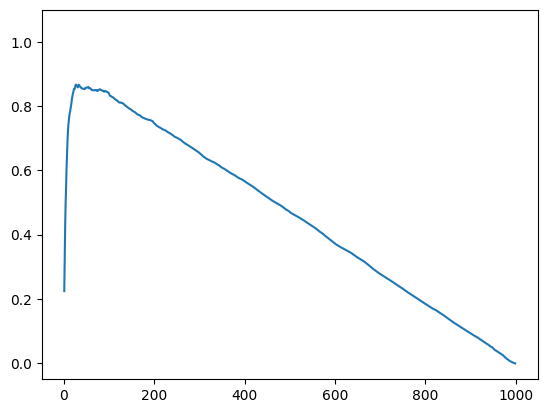

kmax (0-based index) =  26
Qlocal =  0.7326336817425556
Qglobal =  0.9674572922752805


In [9]:
#measuring

print('explained variance ratio:', pca.explained_variance_ratio_[0:5])
print('Explained var ratio cumsum:', pca.explained_variance_ratio_.cumsum())
drm = DRMetrics(np.array(np_emb_state_float[0:1000]), principalComponents[0:1000], emb_recon[0:1000])
print("Qlocal = ", drm.Qlocal) # get Qlocal
drm.report() # print out the summary

/Users/ESMoraEn/miniforge3/envs/causalscm/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/Users/ESMoraEn/miniforge3/envs/causalscm/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


(120311, 64)
Baseline loss with FastICA 0.00110110
Qlocal =  0.5791105734682125
--- Sample Reconstruction (X and Xr) ---
left column: original waveform		 right column: recovered waveform


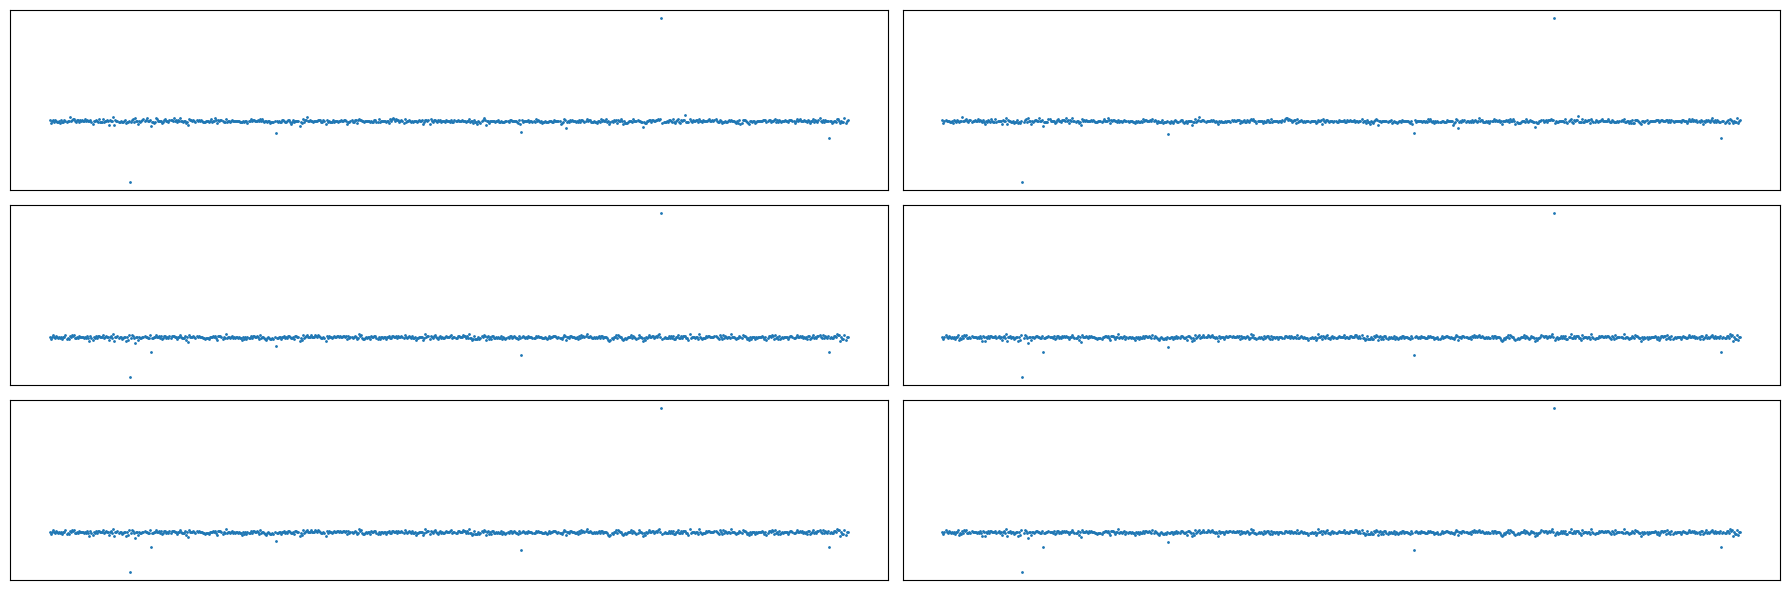

rMSE =  0.006130556172617005
--- Distance Matrices (D and Dz) ---


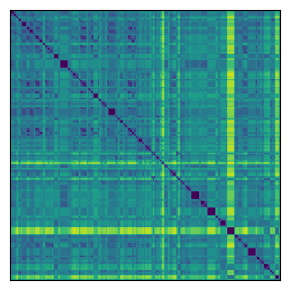

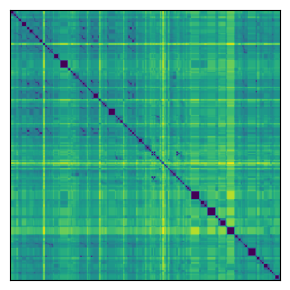

Residual Variance (using Pearson's r) =  0.6055060943755054
Residual Variance (using Spearman's r) =  0.7391111241888643
--- Ranking Matrices (R and Rz) ---


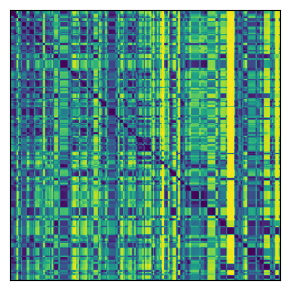

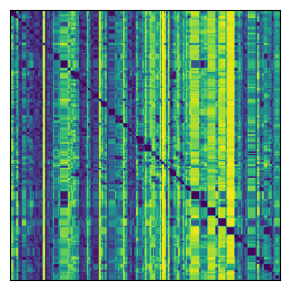

--- Co-ranking Matrix (Q) ---


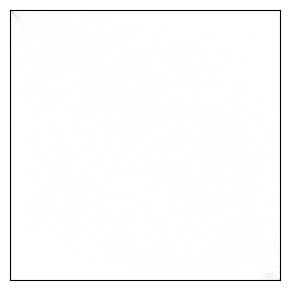

--- Trustworthiness T(k) and Continuity C(k) ---


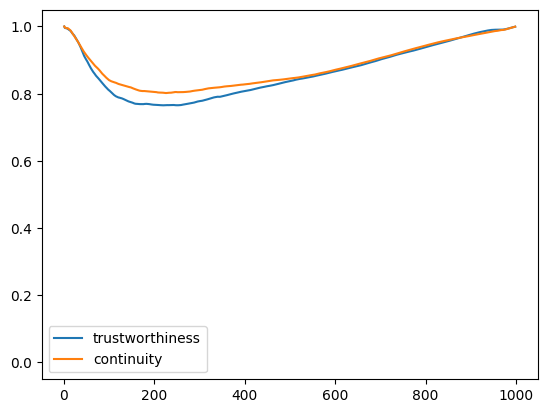

AUC of T =  0.8665748487114943
AUC of C =  0.8811045093495661
--- QNN(k) Curve ---


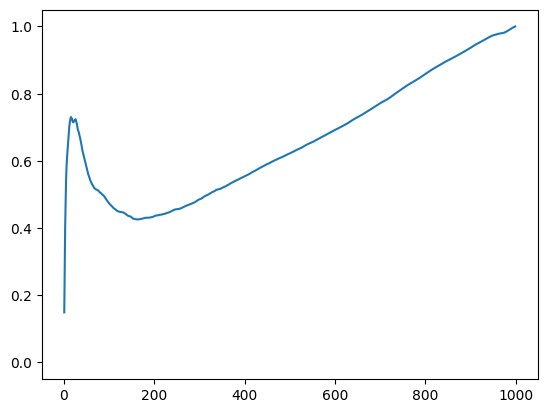

AUC of QNN =  0.6652726806213402
--- LCMC(k) Curve ---


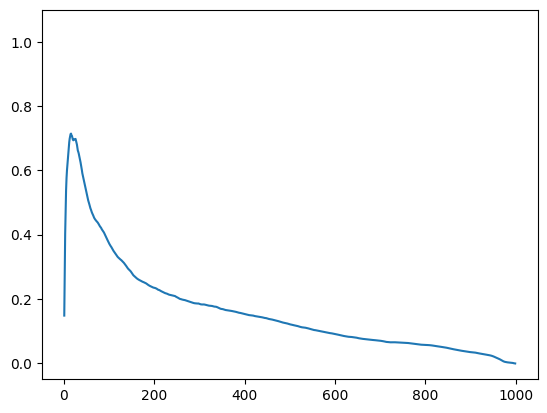

kmax (0-based index) =  15
Qlocal =  0.5791105734682125
Qglobal =  0.6664006288976909


In [25]:
from sklearn.decomposition import FastICA
fica = FastICA(n_components=64)
independentComponents = fica.fit_transform(tensor_emb)
print(independentComponents.shape)
emb_recon_fica = fica.inverse_transform(independentComponents)
loss_function = torch.nn.MSELoss()
loss = loss_function(tensor_emb, torch.Tensor(emb_recon_fica))
print("Baseline loss with FastICA %.8f" %loss)

#measuring
drm = DRMetrics(np.array(np_emb_state_float[0:1000]), independentComponents[0:1000], emb_recon_fica[0:1000])
print("Qlocal = ", drm.Qlocal) # get Qlocal
drm.report() # print out the summary

In [20]:
class Autoenc(torch.nn.Module):
   def __init__(self):
      super().__init__()

      self.encoder = torch.nn.Sequential(
         torch.nn.Linear(768, 512),
         torch.nn.ReLU(True),
         #torch.nn.Sigmoid(),
         torch.nn.Linear(512, 256),
         torch.nn.ReLU(True),
         # torch.nn.Sigmoid(),
         torch.nn.Linear(256, 128),
         torch.nn.ReLU(True),
         #torch.nn.Sigmoid(),
         torch.nn.Linear(128, 64),
      )

      self.decoder = torch.nn.Sequential(
         torch.nn.Linear(64, 128),
         torch.nn.ReLU(True),
         #torch.nn.Sigmoid(),
         torch.nn.Linear(128, 256),
         torch.nn.ReLU(True),
         #torch.nn.Sigmoid(),
         torch.nn.Linear(256, 512),
         torch.nn.ReLU(True),
         #torch.nn.Sigmoid(),
         torch.nn.Linear(512, 768),
      )
   def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return encoded, decoded

In [21]:
model = Autoenc()
loss_function = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [22]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device


def train(net, trainloader, NUM_EPOCHS, criterion, device):
    train_loss = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0

        for emb in trainloader:
            optimizer.zero_grad()
            _, outputs = net(emb)
            loss = criterion(outputs, emb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            last_loss = loss.item()
        
        loss_avg = running_loss / len(trainloader)
        train_loss.append(loss_avg)
        print('Epoch {} of {}, Avg. Train Loss: {:.7f}'.format(
            epoch+1, NUM_EPOCHS, loss_avg))
        print(f'epoch [{epoch + 1}/{NUM_EPOCHS}], Last loss:{last_loss}')
    return train_loss

In [23]:
# constants
NUM_EPOCHS = 50
net = Autoenc()

# get the computation device
device = get_device()
print(device)
# load the neural network onto the device
net.to(device)

cpu


Autoenc(
  (encoder): Sequential(
    (0): Linear(in_features=768, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=512, out_features=768, bias=True)
  )
)

In [24]:
train_loss = train(net, loader, NUM_EPOCHS, loss_function, device)


Epoch 1 of 50, Avg. Train Loss: 0.1848113
epoch [1/50], Last loss:0.18501877784729004
Epoch 2 of 50, Avg. Train Loss: 0.1848111
epoch [2/50], Last loss:0.18283189833164215
Epoch 3 of 50, Avg. Train Loss: 0.1848113
epoch [3/50], Last loss:0.18527966737747192
Epoch 4 of 50, Avg. Train Loss: 0.1848111
epoch [4/50], Last loss:0.18234483897686005
Epoch 5 of 50, Avg. Train Loss: 0.1848110
epoch [5/50], Last loss:0.18212810158729553
Epoch 6 of 50, Avg. Train Loss: 0.1848113
epoch [6/50], Last loss:0.18584080040454865
Epoch 7 of 50, Avg. Train Loss: 0.1848108
epoch [7/50], Last loss:0.17912177741527557
Epoch 8 of 50, Avg. Train Loss: 0.1848113
epoch [8/50], Last loss:0.18535244464874268
Epoch 9 of 50, Avg. Train Loss: 0.1848116
epoch [9/50], Last loss:0.18984083831310272
Epoch 10 of 50, Avg. Train Loss: 0.1848112
epoch [10/50], Last loss:0.18376219272613525
Epoch 11 of 50, Avg. Train Loss: 0.1848110
epoch [11/50], Last loss:0.1812668740749359
Epoch 12 of 50, Avg. Train Loss: 0.1848114
epoch [1

In [15]:
tensor_emb.shape

torch.Size([120311, 768])

In [16]:
test_loader = DataLoader(tensor_emb, batch_size=1)

emb_enc_list = []
emb_recon_list = []

with torch.inference_mode():
    net.eval()
    for emb in test_loader:
   
        #X_batch = X_batch.to(device)
        emb_enc, emb_recon = net(emb)       
        emb_enc_list.append(emb_enc.cpu().numpy())
        emb_recon_list.append(emb_recon.cpu().numpy())

print(len(emb_recon_list))
print(len(emb_enc_list))

120311
120311


In [23]:
print(np.array(np_emb_state_float[0:1000]).shape)
enc_emb = np.squeeze(np.array(emb_enc_list))[0:1000]
recon_emb = np.squeeze(np.array(emb_recon_list))[0:1000]

print(enc_emb.shape)
print(recon_emb.shape)

(1000, 768)
(1000, 64)
(1000, 768)


Qlocal =  0.6821449215589498
--- Sample Reconstruction (X and Xr) ---
left column: original waveform		 right column: recovered waveform


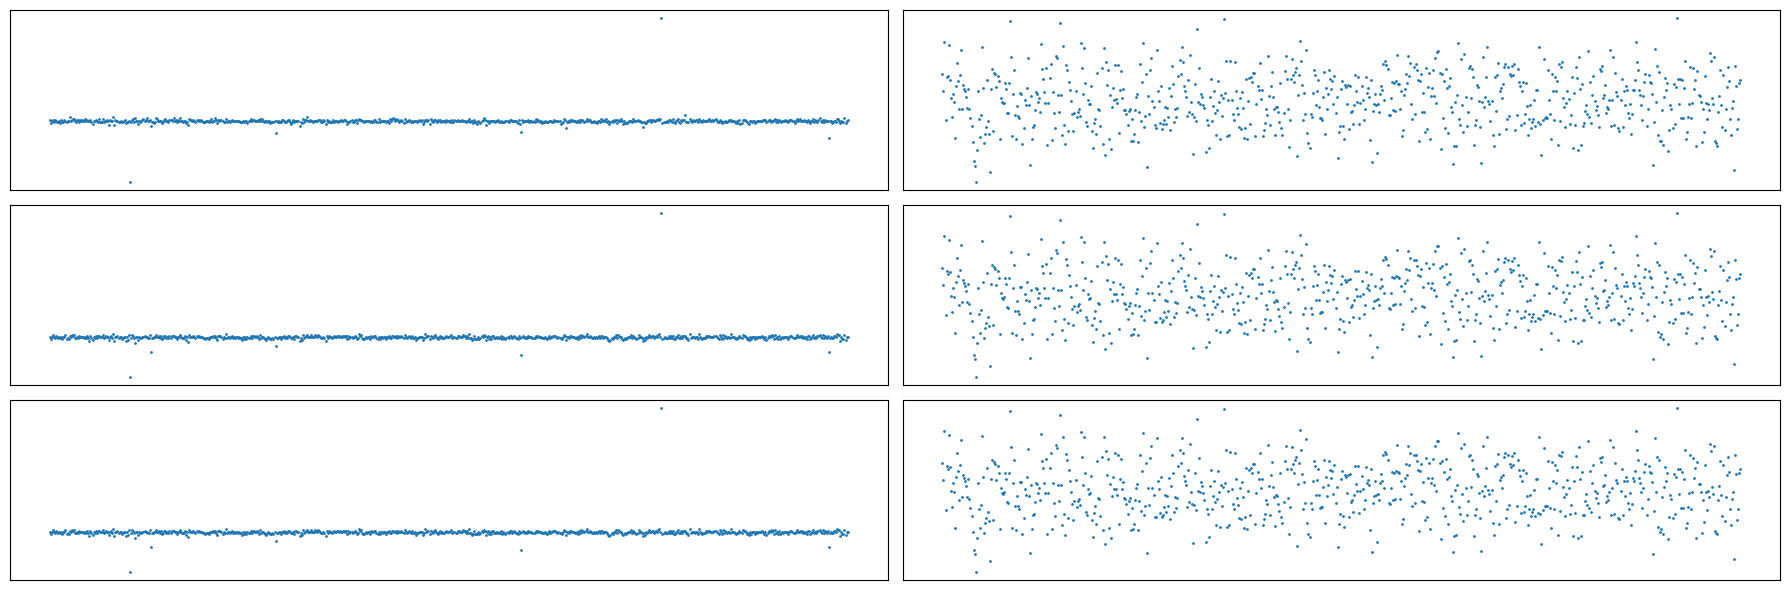

rMSE =  1.0093863310777256
--- Distance Matrices (D and Dz) ---


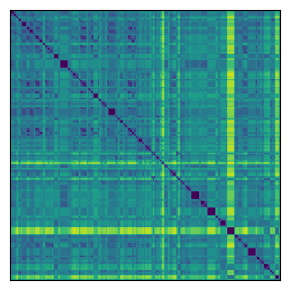

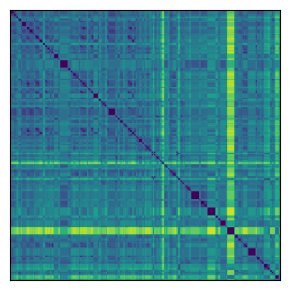

Residual Variance (using Pearson's r) =  0.08663386755344704
Residual Variance (using Spearman's r) =  0.1453266595938344
--- Ranking Matrices (R and Rz) ---


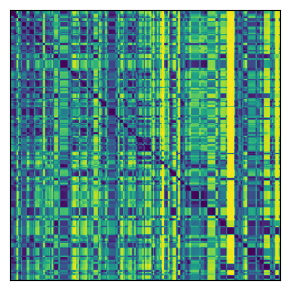

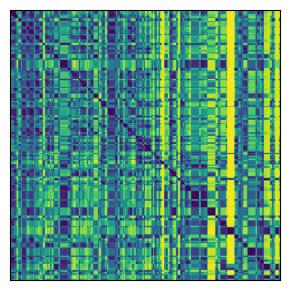

--- Co-ranking Matrix (Q) ---


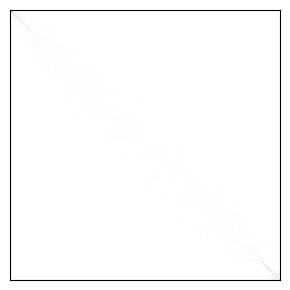

--- Trustworthiness T(k) and Continuity C(k) ---


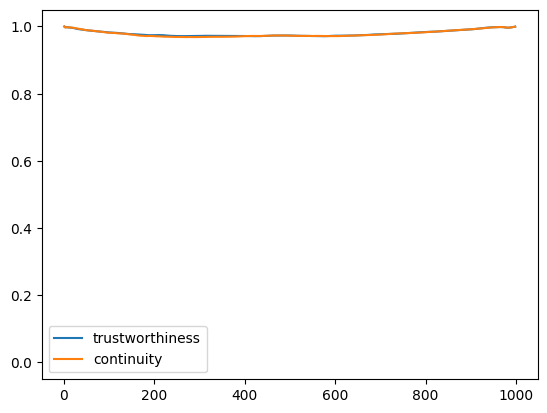

AUC of T =  0.9792604411538687
AUC of C =  0.9784819357517776
--- QNN(k) Curve ---


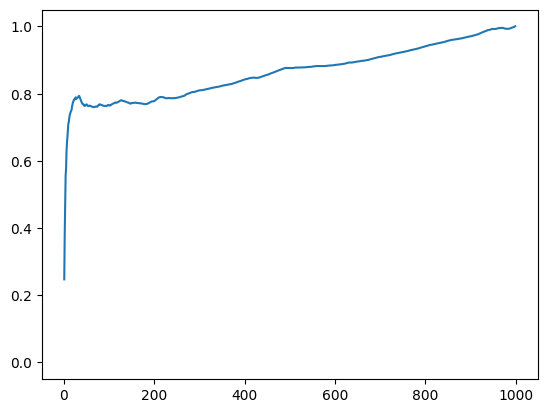

AUC of QNN =  0.8639128741652903
--- LCMC(k) Curve ---


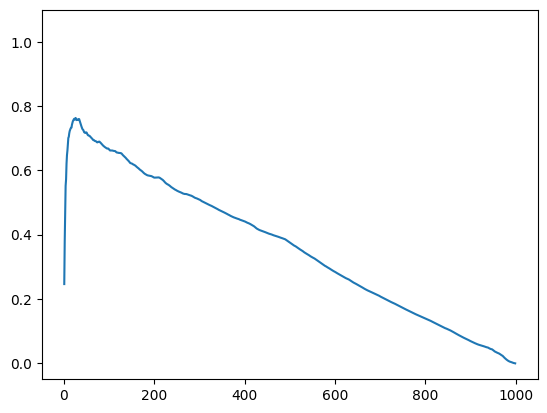

kmax (0-based index) =  25
Qlocal =  0.6821449215589498
Qglobal =  0.8685526268776338


In [24]:
drm = DRMetrics(np.array(np_emb_state_float[0:1000]),enc_emb, recon_emb)
print("Qlocal = ", drm.Qlocal) # get Qlocal
drm.report() # print out the summary

In [43]:
total_var = torch.var(tensor_emb)
total_var_approx = torch.var(torch.Tensor(np.array(y_pred_list)))

cumulative_percent_variance = (total_var_approx / total_var) * 100
print(cumulative_percent_variance)

tensor(1.4712)


In [ ]:
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
